In [ ]:
###################################
## Goal: Develop a basic outline so they we can devide and concur different parts of the project

## Note: All functions will be explicitly defined within this file for ease. In actual implementation it will be stored in a Function.py
###################################

In [ ]:
##### Some Update Timelines
### 11/10/2024 - Implementing the monthly data into our series - Our Strategy now goes back to 1975.
### 11/18/2024 - Going back to 1973 - We will use a 3 Month Moving Average Strategy

In [ ]:
'''
Roadmap

1.Build out a portfolio A based on a traditional 60/40 asset allocation with bloomberg ticker LUATTRUU Index for the 40% bond allocation.
The bloomberg terminal has monthly data starting 1973 and daily data starting in 1994. For the 60% equities, use bloomberg ticker SPXT Index with data starting in 1989 and
SPX Index going back to 1973 (it would be nice but not necessary to find S&P 500 total return data prior to 1989).

2.Record:
•	Compound annualized growth
•	Annualized volatility
•	Annualized downside deviation
•	Max drawdown each year
•	Annualized Sharpe Ratio
•	Annualized Sortino Ratio
•	Annualized Omega Ratio
•	Annualized Calmar Ratio

3.  Backtest an alternative Portfolio B with size of this allocation adjustable and using data going back to 1972.
Initially, the alternative strategy should be the XAU trade model outlined below, with the potential to test other alternative strategies in the future.
Record monthly performance of Portfolio B over the course of historical backtest and record the same overall performance metrics used for Portfolio A
Use ticker XAU Curncy and SPX Index. The trade trigger is XAU bull trend aligned simultaneously with SPX/XAU ratio bear trend.
The trade triggers and exits can be optimized based on any combination of smoothed moving average crosses. 5,20,63,252 using daily data. 4,13,52 using weekly closing price data.
3 and 12 for monthly closing data.

Trade trigger examples:
•	20 day < 252 day  for SPX/XAU and then on day 20 crosses > 252 for XAU, the model goes long XAU
•	4 week > 13 week for XAU and then when the 4 week crosses below the 13 week moving avg for SPX/XAU, the model goes long XAU

4.  Combine Portfolio A with Portfolio B to create Portfolio C using an initial 10% allocation (if 60/40 portfolio size = $100 then alt strategy =$10)
If initial findings do not reflect the XAU trade model being beneficial to adding resiliency to the initial portfolio, please reach out and we will provide other alternative strategy ideas.
'''

'\nRoadmap\n\n1.Build out a portfolio A based on a traditional 60/40 asset allocation with bloomberg ticker LUATTRUU Index for the 40% bond allocation. \nThe bloomberg terminal has monthly data starting 1973 and daily data starting in 1994. For the 60% equities, use bloomberg ticker SPXT Index with data starting in 1989 and \nSPX Index going back to 1973 (it would be nice but not necessary to find S&P 500 total return data prior to 1989).\n\n2.Record:\n•\tCompound annualized growth\n•\tAnnualized volatility\n•\tAnnualized downside deviation\n•\tMax drawdown each year\n•\tAnnualized Sharpe Ratio\n•\tAnnualized Sortino Ratio\n•\tAnnualized Omega Ratio\n•\tAnnualized Calmar Ratio\n\n3.  Backtest an alternative Portfolio B with size of this allocation adjustable and using data going back to 1972. \nInitially, the alternative strategy should be the XAU trade model outlined below, with the potential to test other alternative strategies in the future. \nRecord monthly performance of Portfolio

In [1]:
pip install quantstats


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.9 MB/s eta 0:00:00


In [2]:
# Packages
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
import numpy as np
import pandas as pd
import quantstats as qs
import sys
import os

# Check directory
print("Current Working Directory:", os.getcwd())

# Set pandas display precision to three decimal places
pd.options.display.float_format = '{:.4f}'.format

Current Working Directory: /content


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Read in Data
data = pd.read_excel('/content/drive/MyDrive/equity_bond_gold.xlsx', na_values=['#N/A N/A'], sheet_name='equity_bond_gold_price')

# Rename the specified columns
data = data.rename(columns={
    'LUATTRUU Index': 'Bond',
    'SPXT Index': 'SP500_tr',
    'SPX Index': 'SP500',
    'XAU Curncy': 'Gold'
})

data.head(2)

,Dates,Bond,SP500_tr,SP500,Gold
0,1973-02-01,98.9900,NaN,114.7600,65.1400
1,1973-02-02,98.9900,NaN,114.3500,65.1400


In [5]:
'''
THESE ARE GENERAL NOTES ABOUT OUR DATA:
1) Our BOND DATA does not become daily until 03-01-1994
2) Our GOLD DATA does not become daily until 01-01-1975
-- THIS ABOVE FACT IS KEY -> Looking above we can see that this would have been a prime moment to invest in gold therefore we would like to showcase this in our portfolio
-- We will need to split our trend analysis that is for the first two years use monthly data and then convert into monthly
3) Our SP500 TR (which includes dividends) only begin in 09-11-1989
-- THIS creates a problem for reporting the true return of the base port (CURRENTLY WE ARE ONLY USING PRICE RETURNS)
'''

'\nTHESE ARE GENERAL NOTES ABOUT OUR DATA:\n1) Our BOND DATA does not become daily until 03-01-1994\n2) Our GOLD DATA does not become daily until 01-01-1975\n-- THIS ABOVE FACT IS KEY -> Looking above we can see that this would have been a prime moment to invest in gold therefore we would like to showcase this in our portfolio\n-- We will need to split our trend analysis that is for the first two years use monthly data and then convert into monthly\n3) Our SP500 TR (which includes dividends) only begin in 09-11-1989\n-- THIS creates a problem for reporting the true return of the base port (CURRENTLY WE ARE ONLY USING PRICE RETURNS)\n'

In [6]:
## We will no longer do this!

########################################
# Our GOLD DATA does not become daily until 01-01-1975
# data = data[data['Dates'] >= '1975-01-01']
########################################

# data.head(2)

In [7]:
# Although we will report with monthly data we need daily data to calculate the return of our strategy
def calc_percent(df):
    """
    Calculate the percentage change for each column in the DataFrame, ensuring DateTime indexing.
    """
    # Set 'Dates' column as the index and convert to DateTime if not already
    if 'Dates' in df.columns:
        df['Dates'] = pd.to_datetime(df['Dates'])
        df.set_index('Dates', inplace=True)

    # Create a new DataFrame for the percentage changes, maintaining the DateTime index
    df_percent = pd.DataFrame(index=df.index)

    # Calculate the percentage change for each column and add it to the new DataFrame
    for col in df.columns:
        df_percent[col + '_pctchange'] = df[col].pct_change().fillna(0)

    return df_percent


# Calculate percentage changes for each column starting from the second column onward
returns_daily = calc_percent(data)
returns_daily


,Bond_pctchange,SP500_tr_pctchange,SP500_pctchange,Gold_pctchange
Dates,,,,
1973-02-01,0.0000,0.0000,0.0000,0.0000
1973-02-02,0.0000,0.0000,-0.0036,0.0000
1973-02-05,0.0000,0.0000,-0.0010,0.0000
1973-02-06,0.0000,0.0000,0.0019,0.0000
1973-02-07,0.0000,0.0000,-0.0069,0.0000
...,...,...,...,...
2024-10-28,-0.0013,0.0027,0.0027,-0.0019
2024-10-29,0.0006,0.0016,0.0016,0.0118
2024-10-30,-0.0006,-0.0033,-0.0033,0.0046


In [8]:
### Now We will Report Monthly Returns Not Daily Returns so we need to adjust accoirdinly.

# Resample daily data to monthly frequency
def resample_to_monthly(df):
    """
    Resample daily data to monthly data by taking the last available data point in each month.
    """
    # Ensure 'Dates' is datetime and set as index
    if 'Dates' in df.columns:
        df['Dates'] = pd.to_datetime(df['Dates'])
        df.set_index('Dates', inplace=True)
    else:
        df.index = pd.to_datetime(df.index)

    # Resample to monthly data, taking the last available data point in each month
    df_monthly = df.resample('ME').last()
    return df_monthly

# Lets Get Our Monthly Data
monthly_data = resample_to_monthly(data)
monthly_data

,Bond,SP500_tr,SP500,Gold
Dates,,,,
1973-02-28,98.7300,NaN,111.6800,74.2000
1973-03-31,98.7300,NaN,111.5200,84.3700
1973-04-30,99.6600,NaN,106.9700,90.5000
1973-05-31,99.8800,NaN,104.9500,101.9600
1973-06-30,100.1500,NaN,104.2600,120.1200
...,...,...,...,...
2024-07-31,2306.8400,12052.0900,5522.3000,2447.6000
2024-08-31,2336.3500,12344.4300,5648.4000,2503.3900
2024-09-30,2364.4400,12608.0700,5762.4800,2634.5800


In [9]:
def calc_monthly_percent_changes(df, from_daily=False):
    """
    Calculate the percentage change for each column in the DataFrame.

    Parameters:
    df : pandas DataFrame - The input DataFrame with monthly price data or daily return data.
    from_daily : bool - If True, calculates cumulative monthly returns from daily data.
                       If False, calculates percentage changes for monthly price data.
    """
    if from_daily:
        # Resample daily return data to get cumulative monthly returns
        df_monthly = (1 + df).resample('ME').prod() - 1  # Monthly cumulative return
    else:
        # Assume monthly price data, calculate the monthly percentage change
        df_monthly = df.pct_change().fillna(0)

    # Rename columns to indicate percentage change
    df_monthly.columns = [col + '_pctchange' for col in df_monthly.columns]

    return df_monthly

# Get Our Monthly Returns
returns_monthly = calc_monthly_percent_changes(monthly_data)

# Add a weighted 'ports_pctchange' column
returns_monthly['ports_pctchange'] = 0.6 * returns_monthly['SP500_pctchange'] + 0.4 * returns_monthly['Bond_pctchange']

returns_monthly.head(5)

,Bond_pctchange,SP500_tr_pctchange,SP500_pctchange,Gold_pctchange,ports_pctchange
Dates,,,,,
1973-02-28,0.0000,0.0000,0.0000,0.0000,0.0000
1973-03-31,0.0000,0.0000,-0.0014,0.1371,-0.0009
1973-04-30,0.0094,0.0000,-0.0408,0.0727,-0.0207
1973-05-31,0.0022,0.0000,-0.0189,0.1266,-0.0104
1973-06-30,0.0027,0.0000,-0.0066,0.1781,-0.0029


In [10]:
#### Function to Calculate Port Returns - Note this assumes we are taking in monthly data.

def calculate_max_drawdown(df, column_name):
    """
    Calculate the max drawdown for the entire period in a DataFrame with a DateTime index.
    """
    # Ensure the index is a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DateTimeIndex.")

    cumulative_returns = (1 + df[column_name]).cumprod()  # Calculate cumulative returns
    peak = cumulative_returns.cummax()  # Calculate rolling maximum of cumulative returns
    drawdown = (cumulative_returns - peak) / peak  # Calculate drawdown
    max_drawdown = drawdown.min()  # Return the maximum drawdown

    return max_drawdown



def calculate_performance_metrics(df, column_name):
    """
    Calculate various performance metrics for a given DataFrame with a DateTimeIndex.
    The annualization factor is set to 12 for monthly data.
    """
    annualization_factor = 12  # Set annualization factor to 12 for monthly data

    # Ensure the specified column exists
    if column_name not in df.columns:
        raise ValueError(f"The DataFrame must contain a '{column_name}' column.")

    # Drop missing values in returns
    returns = df[column_name].dropna()

    # Annualized returns (Compound Annualized Growth Rate - CAGR)
    cumulative_return = (1 + returns).prod() - 1
    years = len(returns) / annualization_factor
    cagr = (1 + cumulative_return) ** (1 / years) - 1

    # Annualized volatility
    annualized_volatility = returns.std() * np.sqrt(annualization_factor)

    # Annualized downside deviation (only considers negative returns)
    downside_returns = returns[returns < 0]
    annualized_downside_deviation = downside_returns.std() * np.sqrt(annualization_factor)

    # Annualized Sharpe Ratio (Assuming risk-free rate is zero)
    sharpe_ratio = cagr / annualized_volatility

    # Annualized Sortino Ratio
    sortino_ratio = cagr / annualized_downside_deviation

    # Annualized Omega Ratio (Using threshold of 0 for the numerator)
    positive_excess_returns = returns[returns > 0].sum()
    negative_excess_returns = abs(returns[returns < 0].sum())
    omega_ratio = positive_excess_returns / negative_excess_returns

    # Max drawdown for the full period
    max_drawdown = calculate_max_drawdown(df, column_name)

    # Annualized Calmar Ratio
    calmar_ratio = cagr / abs(max_drawdown)

    # Prepare results as a DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['CAGR', 'Annualized Volatility', 'Annualized Downside Deviation', 'Sharpe Ratio',
                   'Sortino Ratio', 'Omega Ratio', 'Max Drawdown', 'Calmar Ratio'],
        'Value': [cagr, annualized_volatility, annualized_downside_deviation, sharpe_ratio,
                  sortino_ratio, omega_ratio, max_drawdown, calmar_ratio]
    })

    return metrics_df

# Now let us calculate the performance of our base model

base_port_performance = calculate_performance_metrics(returns_monthly, column_name='ports_pctchange')
base_port_performance


,Metric,Value
0,CAGR,0.0756
1,Annualized Volatility,0.0965
2,Annualized Downside Deviation,0.0654
3,Sharpe Ratio,0.7837
4,Sortino Ratio,1.1567
5,Omega Ratio,1.8338
6,Max Drawdown,-0.3191
7,Calmar Ratio,0.2370


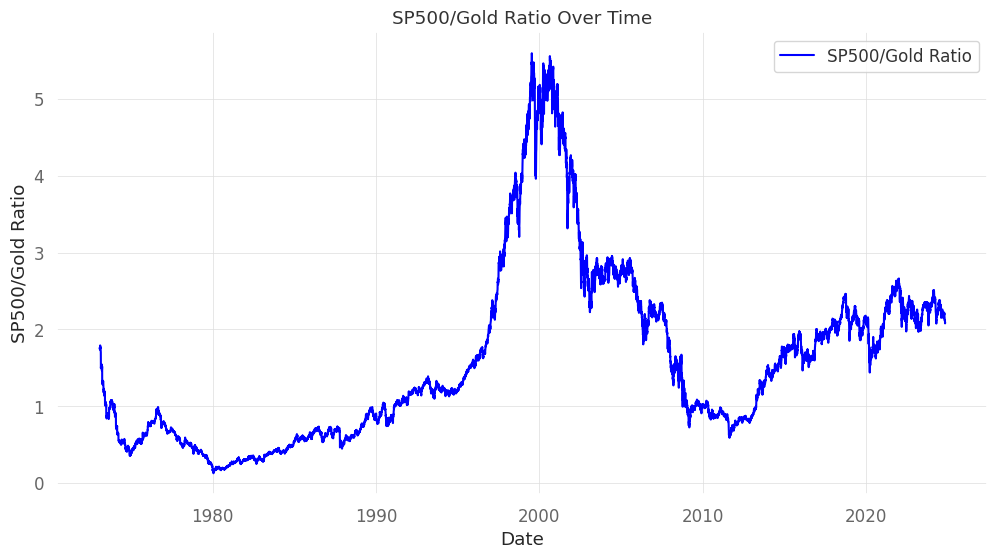

In [11]:
# Calculate the ratio of SP500 to Gold
data['SP500_Gold_Ratio'] = data['SP500'] / data['Gold']
data

# Plotting the SP500_Gold_Ratio
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['SP500_Gold_Ratio'], label='SP500/Gold Ratio', color='blue')
plt.title('SP500/Gold Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('SP500/Gold Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
########################################################################################################################################################################################################################################################################################################################
########################################################################################################################################################################################################################################################################################################################
########################################################################################################################################################################################################################################################################################################################

In [ ]:
# Functions That We Will Need!

In [12]:
def generate_signal_pre1975(price_series):
    """
    Generates trading signals for the pre-1975 period based on monthly data. Buy if the current price is greater than the 3-month moving average.

    Args:
        price_series (Series): The price series to analyze (monthly data).

    Returns:
        DataFrame: DataFrame containing the 'signal' column.
    """
    df = pd.DataFrame(price_series)

    # Calculate 3-month moving average
    df['ma_3'] = price_series.rolling(window=3).mean()

    # Generate signals: 1 if current price > 3-month moving average, 0 otherwise
    df['signal'] = np.where(df[price_series.name] > df['ma_3'], 1, 0)

    # Keep only the 'signal' column
    return df[['signal']]

In [13]:
#### This is where we need to make major adjustments!

def generate_signal(price_series, short1, long1, short2, long2):
    """
    Generates a trading signal based on two EMA crossover strategies.

    Args:
        price_series (Series): The price series to analyze.
        short1 (int): Short-term EMA period for the first strategy.
        long1 (int): Long-term EMA period for the first strategy.
        short2 (int): Short-term EMA period for the second strategy.
        long2 (int): Long-term EMA period for the second strategy.

    Returns:
        DataFrame: DataFrame containing the 'signal' column.
    """
    df = pd.DataFrame(price_series)

    # Calculate EMAs for both strategies
    df['long_ma1'] = price_series.ewm(span=long1, adjust=False).mean()
    df['short_ma1'] = price_series.ewm(span=short1, adjust=False).mean()
    df['long_ma2'] = price_series.ewm(span=long2, adjust=False).mean()
    df['short_ma2'] = price_series.ewm(span=short2, adjust=False).mean()

    # Generate signals: 1 if short_ma > long_ma, 0 otherwise
    df['signal1'] = np.where(df['short_ma1'] > df['long_ma1'], 1, 0)
    df['signal2'] = np.where(df['short_ma2'] > df['long_ma2'], 1, 0)

    # Signal = 1 if both signals are active, 0.5 if only one is active, and 0 if neither are active
    df['signal'] = np.where((df['signal1'] == 1) & (df['signal2'] == 1), 1,
                        np.where(df['signal1'] != df['signal2'], 0.5, 0))

    # Keep only the 'signal' column
    return df[['signal']]


In [14]:
def calculate_position_returns(signal_df, returns_series):
    """
    Calculates the returns based on holding positions according to signals, with a one-day delay.

    Args:
        signal_df (DataFrame): DataFrame containing the 'signal' column indicating the position (1, 0.5, or 0).
        returns_series (Series): Series of daily returns corresponding to the price series.

    Returns:
        DataFrame: DataFrame containing the shifted signals and the resulting position returns.
    """
    # Shift the signal by one day to implement the one-day delay
    signal_df['shifted_signal'] = signal_df['signal'].shift(1)

    # Calculate returns by multiplying returns with the delayed signal
    signal_df['position_returns'] = returns_series * signal_df['shifted_signal']

    # Optional: Calculate cumulative returns for a summary view
    # signal_df['cumulative_returns'] = (1 + signal_df['position_returns']).cumprod() - 1

    return signal_df[['shifted_signal', 'position_returns']]#, 'cumulative_returns']]

In [15]:
## We Need To Split The Dates
# 1) Monthly data prior to 1975
monthly_data_till_1975 = monthly_data[monthly_data.index < '1975-01-01']
# 2) Daily data after 1975
daily_data_after_1975 = data[data.index >= '1975-01-01']

In [16]:
# Let Us do : Generate signals and position returns for pre-1975
gold_price_pre1975 = monthly_data_till_1975['Gold']
signal_pre1975 = generate_signal_pre1975(gold_price_pre1975)


In [17]:
returns_pre1975 = calc_monthly_percent_changes(monthly_data_till_1975)
gold_returns_pre1975 = returns_pre1975['Gold_pctchange']
gold_strategy_pre1975 = calculate_position_returns(signal_pre1975, gold_returns_pre1975)
gold_strategy_pre1975

<ipython-input-9-bda5cc8eff2d>:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_monthly = df.pct_change().fillna(0)


,shifted_signal,position_returns
Dates,,
1973-02-28,NaN,NaN
1973-03-31,0.0000,0.0000
1973-04-30,0.0000,0.0000
1973-05-31,1.0000,0.1266
1973-06-30,1.0000,0.1781
1973-07-31,1.0000,0.0004
1973-08-31,1.0000,-0.1116
1973-09-30,0.0000,-0.0000
1973-10-31,0.0000,-0.0000


In [18]:
# Step 3: Generate signals and position returns for post-1975
gold_price_post1975 = daily_data_after_1975['Gold']
signal_post1975 = generate_signal(gold_price_post1975, 20, 63, 50, 200)
returns_post1975 = calc_percent(daily_data_after_1975)
gold_returns_post1975 = returns_post1975['Gold_pctchange']
gold_strategy_post1975 = calculate_position_returns(signal_post1975, gold_returns_post1975)
gold_strategy_post1975

,shifted_signal,position_returns
Dates,,
1975-01-01,NaN,NaN
1975-01-02,0.0000,-0.0000
1975-01-03,0.0000,-0.0000
1975-01-06,0.0000,-0.0000
1975-01-07,0.0000,-0.0000
...,...,...
2024-10-28,1.0000,-0.0019
2024-10-29,1.0000,0.0118
2024-10-30,1.0000,0.0046


In [19]:
# Step 4: Resample post-1975 data to monthly
gold_strategy_post1975['cumulative_return'] = (1 + gold_strategy_post1975['position_returns']).cumprod()
monthly_cumulative_returns = gold_strategy_post1975['cumulative_return'].resample('ME').last()
monthly_returns_post1975 = monthly_cumulative_returns.pct_change().fillna(0)
monthly_returns_post1975


,cumulative_return
Dates,
1975-01-31,0.0000
1975-02-28,-0.0095
1975-03-31,-0.0152
1975-04-30,0.0000
1975-05-31,0.0000
...,...
2024-07-31,0.0519
2024-08-31,0.0228
2024-09-30,0.0524


In [20]:
# Step 5: Combine pre-1975 and post-1975 data
combined_position_returns = pd.concat([gold_strategy_pre1975['position_returns'], monthly_returns_post1975], axis=0).sort_index()

gold_strategy_combined = pd.DataFrame({
    'position_returns': combined_position_returns,
}).dropna()


In [21]:
# Step 6: Calculate performance metrics
gold_performance = calculate_performance_metrics(gold_strategy_combined, column_name='position_returns')
gold_performance

,Metric,Value
0,CAGR,0.0710
1,Annualized Volatility,0.1499
2,Annualized Downside Deviation,0.1012
3,Sharpe Ratio,0.4733
4,Sortino Ratio,0.7012
5,Omega Ratio,1.7376
6,Max Drawdown,-0.4242
7,Calmar Ratio,0.1673


In [22]:
# Step 1: Calculate performance metrics for the Gold Strategy
gold_strategy_performance = calculate_performance_metrics(gold_strategy_combined, column_name='position_returns')

# Step 2: Align 'returns_monthly' and 'gold_strategy_combined'
aligned_data = pd.DataFrame({
    'ports_pctchange': returns_monthly['ports_pctchange'],
    'gold_position_returns': gold_strategy_combined['position_returns']
}).dropna()

# Step 3: Create the Leveraged Gold Strategy
leveraged_gold_strategy = pd.DataFrame(
    aligned_data['ports_pctchange'] + 0.1 * aligned_data['gold_position_returns'],
    columns=['Returns']
)

# Step 4: Calculate performance metrics for the Leveraged Gold Strategy
leveraged_gold_strategy_performance = calculate_performance_metrics(leveraged_gold_strategy, column_name='Returns')

# SP500: Performance
SP500_performance = calculate_performance_metrics(returns_monthly, column_name='SP500_pctchange')

# Step 5: Combine the three performance DataFrames
combined_performance = pd.concat(
    [
        base_port_performance.set_index('Metric'),
        gold_strategy_performance.set_index('Metric'),
        leveraged_gold_strategy_performance.set_index('Metric'),
        SP500_performance.set_index('Metric')
    ],
    axis=1,
    keys=['Base Portfolio', 'Gold Strategy', 'Leveraged Strategy','Pure SP500']
)

# Step 6: Display the combined performance metrics
combined_performance

,Base Portfolio,Gold Strategy,Leveraged Strategy,Pure SP500
,Value,Value,Value,Value
Metric,,,,
CAGR,0.0756,0.0710,0.0842,0.0789
Annualized Volatility,0.0965,0.1499,0.0980,0.1539
Annualized Downside Deviation,0.0654,0.1012,0.0661,0.1102
Sharpe Ratio,0.7837,0.4733,0.8586,0.5130
Sortino Ratio,1.1567,0.7012,1.2726,0.7159
Omega Ratio,1.8338,1.7376,1.9328,1.5411
Max Drawdown,-0.3191,-0.4242,-0.3145,-0.5256
Calmar Ratio,0.2370,0.1673,0.2676,0.1502


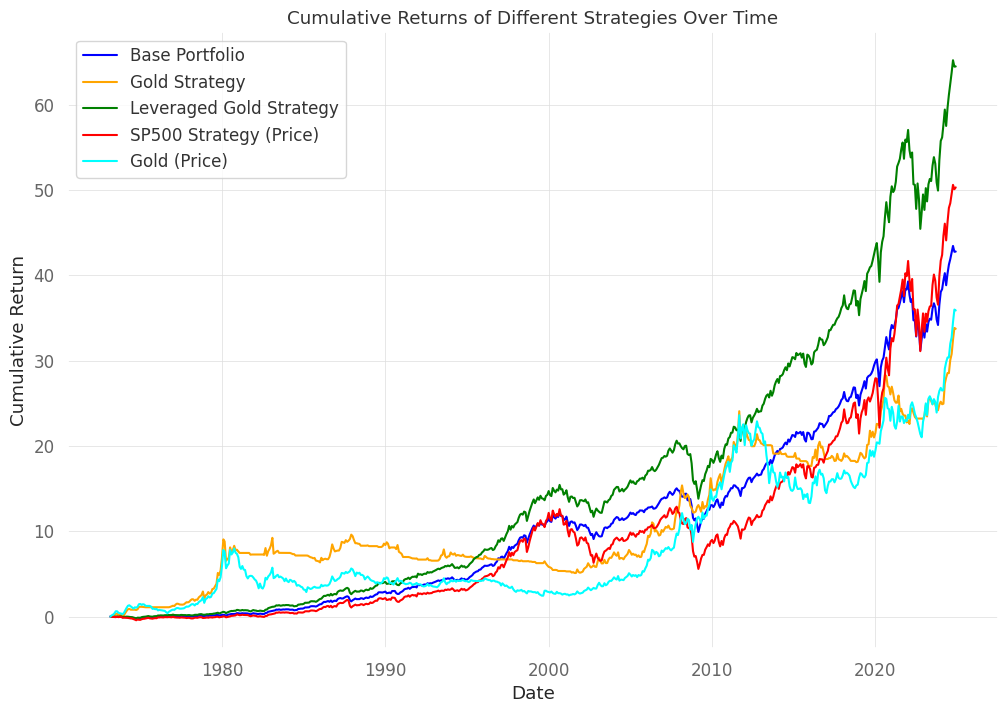

In [23]:
# Creating a cumulative_returns DataFrame that consolidates cumulative returns for each strategy
cumulative_returns = pd.DataFrame({
    'Base Portfolio': (1 + returns_monthly['ports_pctchange']).cumprod() - 1,
    'Gold Strategy': (1 + gold_strategy_combined['position_returns']).cumprod() - 1,
    'Leveraged Gold Strategy': (1 + leveraged_gold_strategy['Returns']).cumprod() - 1,
    'SP500 Strategy (Price)': (1 + returns_monthly['SP500_pctchange']).cumprod() - 1,
    'Gold (Price)': (1 + returns_monthly['Gold_pctchange']).cumprod() - 1,
})

# Plotting the cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns.index, cumulative_returns['Base Portfolio'], label='Base Portfolio', color='blue')
plt.plot(cumulative_returns.index, cumulative_returns['Gold Strategy'], label='Gold Strategy', color='orange')
plt.plot(cumulative_returns.index, cumulative_returns['Leveraged Gold Strategy'], label='Leveraged Gold Strategy', color='green')
plt.plot(cumulative_returns.index, cumulative_returns['SP500 Strategy (Price)'], label='SP500 Strategy (Price)', color='red')
plt.plot(cumulative_returns.index, cumulative_returns['Gold (Price)'], label='Gold (Price)', color='cyan')

# Label and style the plot
plt.title('Cumulative Returns of Different Strategies Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Test Alternative Strategies

## eurekahedge hedge fund index

In [40]:
ehfi251_data = pd.read_excel('/content/drive/MyDrive/EFHI251_Index.xlsx',
                             na_values=['#N/A N/A'],
                             parse_dates=['Date'],
                             index_col='Date')
ehfi251_data.head(2)

,EFHI251
Date,
2024-11-30,758.5294
2024-10-31,740.5690


In [44]:
ehfi251_data = ehfi251_data.sort_index()
# calculate monthly returns
ehfi251_data['Returns'] = ehfi251_data['EFHI251'].pct_change().fillna(0)
# Convert index to DateTimeIndex if it's not already
ehfi251_data.index = pd.to_datetime(ehfi251_data.index)
ehfi251_data.head(2)

,EFHI251,Returns
Date,,
1999-11-30,100.0000,0.0000
1999-12-31,100.0000,0.0000


In [45]:
# Calculate metrics for EHFI251
ehfi251_metrics = calculate_performance_metrics(ehfi251_data, 'Returns')
print(ehfi251_metrics)

                          Metric   Value
0                           CAGR  0.0841
1          Annualized Volatility  0.0524
2  Annualized Downside Deviation  0.0369
3                   Sharpe Ratio  1.6066
4                  Sortino Ratio  2.2784
5                    Omega Ratio  3.2894
6                   Max Drawdown -0.1274
7                   Calmar Ratio  0.6604


In [104]:
# Combine the six performance DataFrames
combined_performance2 = pd.concat(
    [
        base_port_performance.set_index('Metric'),
        gold_strategy_performance.set_index('Metric'),
        leveraged_gold_strategy_performance.set_index('Metric'),
        SP500_performance.set_index('Metric'),
        ehfi251_metrics.set_index('Metric')
    ],
    axis=1,
    keys=['Base Portfolio', 'Gold Strategy', 'Leveraged Strategy','Pure SP500','EFHI251']
)

# Display the combined performance metrics
combined_performance2

,Base Portfolio,Gold Strategy,Leveraged Strategy,Pure SP500,EFHI251
,Value,Value,Value,Value,Value
Metric,,,,,
CAGR,0.0756,0.0710,0.0842,0.0789,0.0841
Annualized Volatility,0.0965,0.1499,0.0980,0.1539,0.0524
Annualized Downside Deviation,0.0654,0.1012,0.0661,0.1102,0.0369
Sharpe Ratio,0.7837,0.4733,0.8586,0.5130,1.6066
Sortino Ratio,1.1567,0.7012,1.2726,0.7159,2.2784
Omega Ratio,1.8338,1.7376,1.9328,1.5411,3.2894
Max Drawdown,-0.3191,-0.4242,-0.3145,-0.5256,-0.1274
Calmar Ratio,0.2370,0.1673,0.2676,0.1502,0.6604


In [86]:
#Calculate Cumulative Returns
ehfi251_data['EHFI251_Cumulative_Returns'] = (1 + ehfi251_data['Returns']).cumprod() - 1


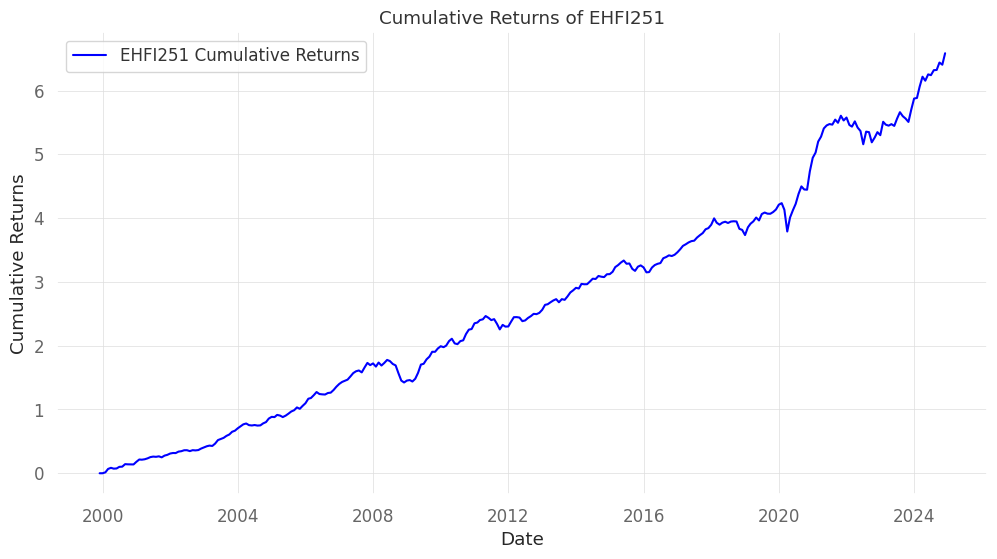

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(ehfi251_data.index, ehfi251_data['EHFI251_Cumulative_Returns'], label='EHFI251 Cumulative Returns', color='blue')
plt.title('Cumulative Returns of EHFI251')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


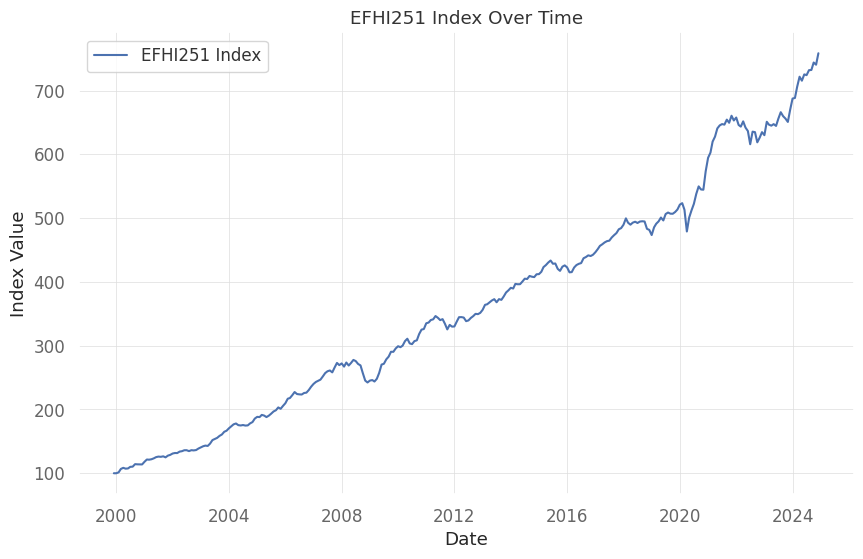

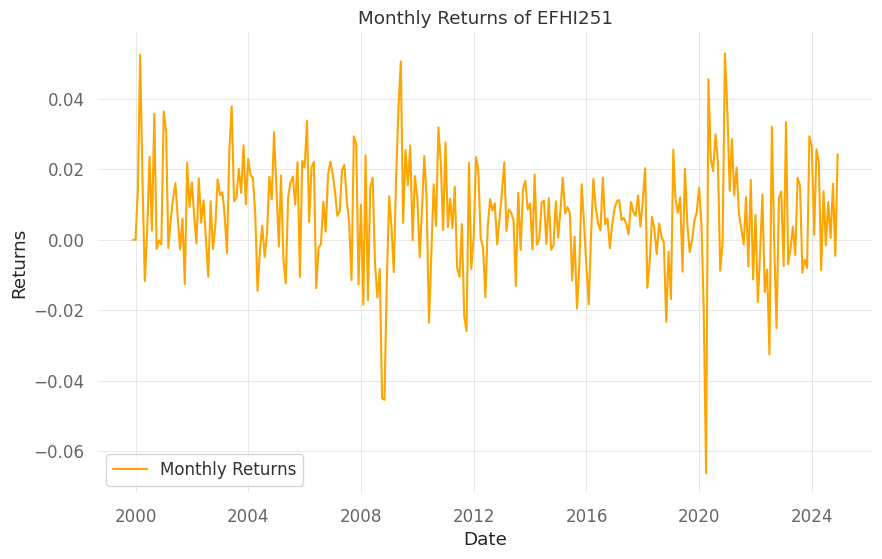

In [46]:
# Plot EFHI251 Index
plt.figure(figsize=(10, 6))
plt.plot(ehfi251_data.index, ehfi251_data['EFHI251'], label='EFHI251 Index')
plt.title('EFHI251 Index Over Time')
plt.xlabel('Date')# Plot EFHI251 Index
plt.figure(figsize=(10, 6))
plt.plot(ehfi251_data.index, ehfi251_data['EFHI251'], label='EFHI251 Index')
plt.title('EFHI251 Index Over Time')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.show()

# Plot Returns
plt.figure(figsize=(10, 6))
plt.plot(ehfi251_data.index, ehfi251_data['Returns'], label='Monthly Returns', color='orange')
plt.title('Monthly Returns of EFHI251')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()
plt.ylabel('Index Value')
plt.legend()
plt.show()



## how the alternative strategy performs well when spy is down


In [50]:
spy_data = pd.read_csv('/content/drive/MyDrive/SPY.csv', na_values=['#N/A N/A'], parse_dates=['Date'], index_col='Date')

# Convert 'Adj_Close' to numeric, coercing errors which will turn non-numeric values into NaNs
spy_data['Adj_Close'] = pd.to_numeric(spy_data['Adj_Close'], errors='coerce')

# Now resample to month end
spy_monthly = spy_data['Adj_Close'].resample('ME').last()

# Calculate the percentage change month-over-month
spy_data['SPY_Monthly_Returns'] = spy_monthly.pct_change().fillna(0)


In [52]:
# Let's make sure they are both timezone-naive for simplicity
spy_data.index = spy_data.index.tz_localize(None)
ehfi251_data.index = ehfi251_data.index.tz_localize(None)

# Filter ehfi251_data to the date range of spy_data
ehfi251_data_filtered = ehfi251_data.loc['2010-01-01':'2020-12-31']

In [103]:
# Merge the data on the index, which is the Date
combined_data = pd.merge(ehfi251_data_filtered, spy_data, left_index=True, right_index=True, how='inner')
combined_data.head(5)

,EFHI251,Returns,Price,Adj_Close,Close,High,Low,Open,Volume,SPY_Monthly_Returns
Date,,,,,,,,,,
2010-03-31,307.2333,0.0238,60,89.4781,117.0,117.5199966430664,116.61000061035156,116.94999694824219,161078700,0.0609
2010-04-30,310.9012,0.0119,81,90.8624,118.80999755859375,121.01000213623047,118.77999877929688,120.87999725341797,270000900,0.0155
2010-06-30,302.4233,-0.0038,123,79.3152,103.22000122070312,104.87999725341797,102.87999725341797,103.91999816894531,284101700,-0.0517
2010-08-31,308.4028,0.0040,166,80.9212,105.30999755859375,105.9800033569336,104.48999786376953,104.91999816894531,273933100,-0.0450
2010-09-30,318.2444,0.0319,187,88.1681,114.12999725341797,115.79000091552734,113.58999633789062,115.05000305175781,287106700,0.0896


In [55]:
# Find periods where SPY had negative returns
down_periods = combined_data[combined_data['SPY_Monthly_Returns'] < 0]

# Calculate the average return of EHFI251 during these down periods
average_return_during_spy_down = down_periods['Returns'].mean()
print(f"Average EHFI251 Return when SPY is down: {average_return_during_spy_down * 100:.2f}%")


Average EHFI251 Return when SPY is down: -0.98%


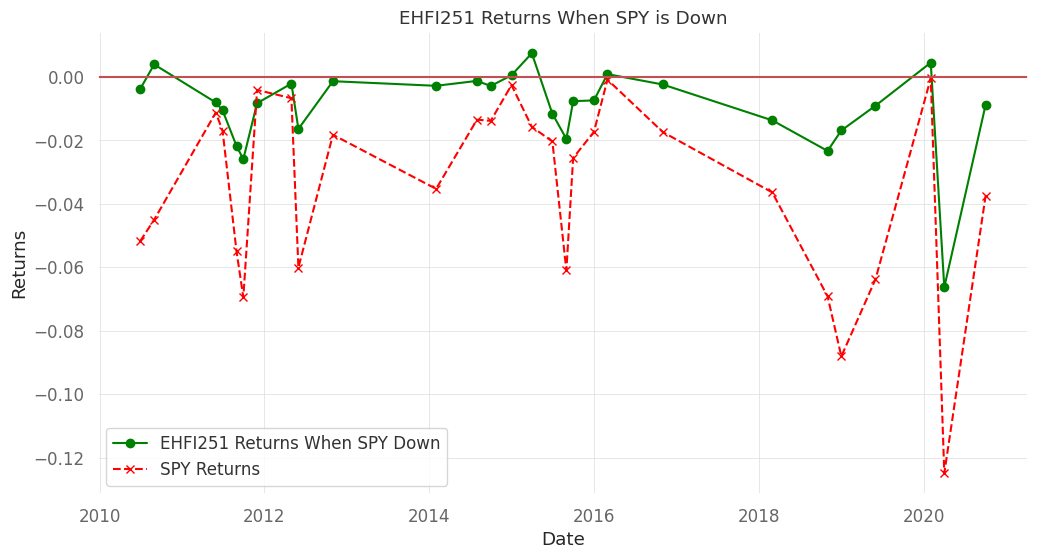

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(down_periods.index, down_periods['Returns'], label='EHFI251 Returns When SPY Down', color='green', marker='o')
plt.plot(down_periods.index, down_periods['SPY_Monthly_Returns'], label='SPY Returns', color='red', linestyle='--', marker='x')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('EHFI251 Returns When SPY is Down')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


## NEIXCTA Index

In [69]:
data_cta = pd.read_excel('/content/drive/MyDrive/NEIXCTA_Index.xlsx',
                             na_values=['#N/A N/A'],
                             parse_dates=['Date'],
                             index_col='Date')
data_cta.sort_index(inplace=True)
data_cta.head(2)

,NEIXCTA
Date,
1999-12-31,1000.0000
2000-01-03,996.7400


In [71]:
# 1. Calculate Daily CTA Returns
cta_daily_returns = data_cta['NEIXCTA'].pct_change().fillna(0)
cta_daily_returns.name = 'CTA_pctchange'

# 2. Convert Daily CTA Returns to Monthly Returns
cta_monthly_returns = (1 + cta_daily_returns).resample('ME').prod() - 1
cta_monthly_returns = cta_monthly_returns.to_frame()

# 3. Calculate CTA Performance Metrics
cta_performance = calculate_performance_metrics(cta_monthly_returns, 'CTA_pctchange')
print(cta_performance)

                          Metric   Value
0                           CAGR  0.0433
1          Annualized Volatility  0.0873
2  Annualized Downside Deviation  0.0475
3                   Sharpe Ratio  0.4961
4                  Sortino Ratio  0.9123
5                    Omega Ratio  1.4703
6                   Max Drawdown -0.1425
7                   Calmar Ratio  0.3039


In [105]:
# Combine the six performance DataFrames
combined_performance3 = pd.concat(
    [
        base_port_performance.set_index('Metric'),
        gold_strategy_performance.set_index('Metric'),
        leveraged_gold_strategy_performance.set_index('Metric'),
        SP500_performance.set_index('Metric'),
        ehfi251_metrics.set_index('Metric'),
        cta_performance.set_index('Metric')
    ],
    axis=1,
    keys=['Base Portfolio', 'Gold Strategy', 'Leveraged Strategy','Pure SP500','EFHI251','NEIXCTA']
)

# Display the combined performance metrics
combined_performance3

,Base Portfolio,Gold Strategy,Leveraged Strategy,Pure SP500,EFHI251,NEIXCTA
,Value,Value,Value,Value,Value,Value
Metric,,,,,,
CAGR,0.0756,0.0710,0.0842,0.0789,0.0841,0.0433
Annualized Volatility,0.0965,0.1499,0.0980,0.1539,0.0524,0.0873
Annualized Downside Deviation,0.0654,0.1012,0.0661,0.1102,0.0369,0.0475
Sharpe Ratio,0.7837,0.4733,0.8586,0.5130,1.6066,0.4961
Sortino Ratio,1.1567,0.7012,1.2726,0.7159,2.2784,0.9123
Omega Ratio,1.8338,1.7376,1.9328,1.5411,3.2894,1.4703
Max Drawdown,-0.3191,-0.4242,-0.3145,-0.5256,-0.1274,-0.1425
Calmar Ratio,0.2370,0.1673,0.2676,0.1502,0.6604,0.3039


In [102]:
cta_monthly_returns.head(5)

,CTA_pctchange,CTA_Cumulative_Returns
Date,,
1999-12-31,0.0000,0.0000
2000-01-31,0.0234,0.0234
2000-02-29,-0.0078,0.0155
2000-03-31,-0.0188,-0.0036
2000-04-30,-0.0145,-0.0180


In [101]:
#Calculate Cumulative Returns
cta_monthly_returns['CTA_Cumulative_Returns'] = (1 + cta_monthly_returns['CTA_pctchange']).cumprod() - 1
cta_monthly_returns.head(5)

,CTA_pctchange,CTA_Cumulative_Returns
Date,,
1999-12-31,0.0000,0.0000
2000-01-31,0.0234,0.0234
2000-02-29,-0.0078,0.0155
2000-03-31,-0.0188,-0.0036
2000-04-30,-0.0145,-0.0180


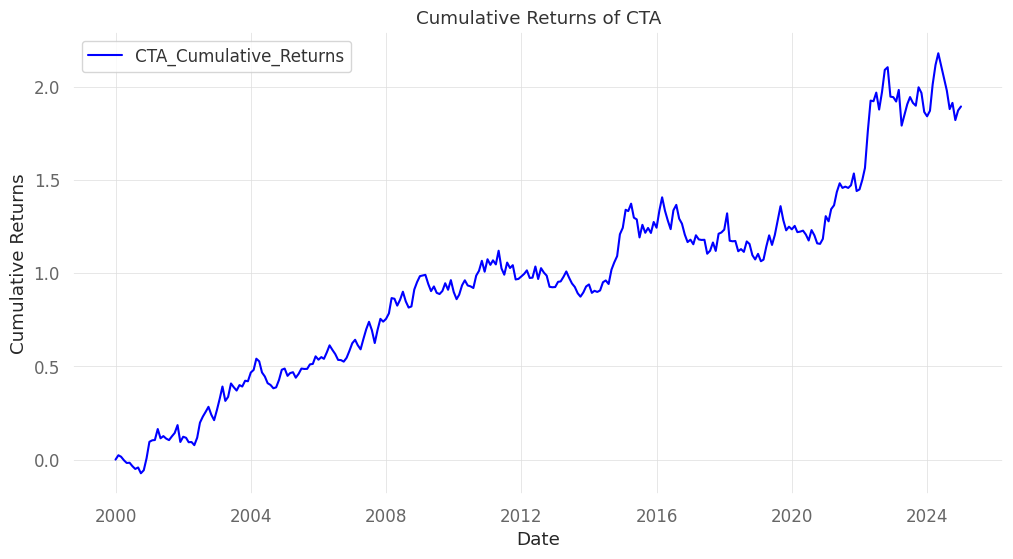

In [92]:
#Plot the Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(cta_monthly_returns.index, cta_monthly_returns['CTA_Cumulative_Returns'], label='CTA_Cumulative_Returns', color='blue')
plt.title('Cumulative Returns of CTA')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


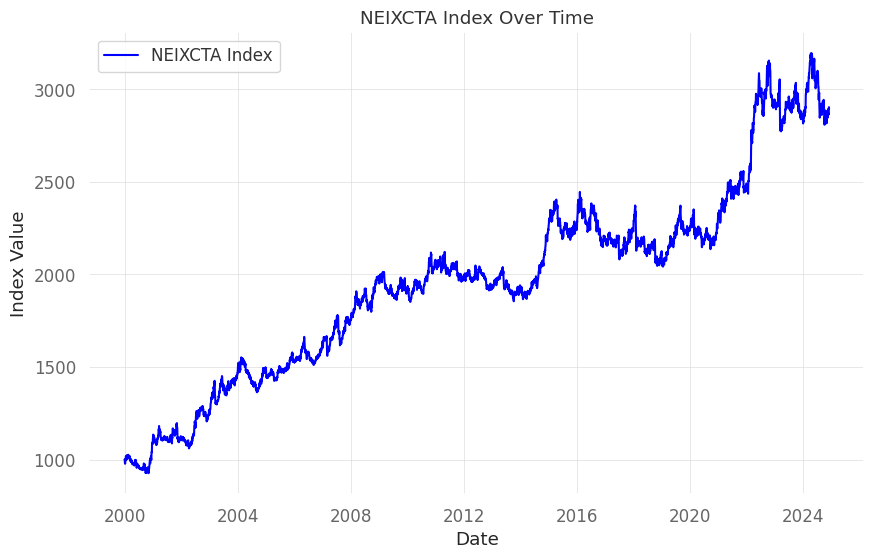

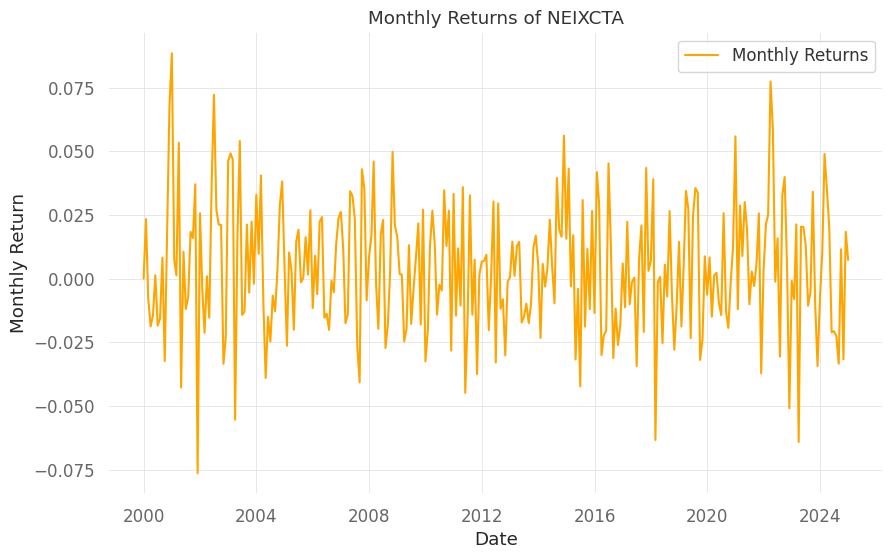

In [93]:
# Plot NEIXCTA Index Over Time
plt.figure(figsize=(10, 6))
plt.plot(data_cta.index, data_cta['NEIXCTA'], label='NEIXCTA Index', color='blue')
plt.title('NEIXCTA Index Over Time')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot Monthly Returns of NEIXCTA
plt.figure(figsize=(10, 6))
plt.plot(cta_monthly_returns.index, cta_monthly_returns['CTA_pctchange'], label='Monthly Returns', color='orange')
plt.title('Monthly Returns of NEIXCTA')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.show()


## how the alternative strategy performs well when spy is down


In [94]:
# Filter cta_monthly_returns to the date range of spy_data
cta_monthly_returns_filtered = cta_monthly_returns.loc['2010-01-01':'2020-12-31']

In [100]:
# Merge the data on the index, which is the Date
combined_data2 = pd.merge(cta_monthly_returns_filtered, spy_data, left_index=True, right_index=True, how='inner')
combined_data2.head(5)

,CTA_pctchange,CTA_Cumulative_Returns,Price,Adj_Close,Close,High,Low,Open,Volume,SPY_Monthly_Returns
Date,,,,,,,,,,
2010-03-31,0.0267,0.9360,60,89.4781,117.0,117.5199966430664,116.61000061035156,116.94999694824219,161078700,0.0609
2010-04-30,0.0139,0.9628,81,90.8624,118.80999755859375,121.01000213623047,118.77999877929688,120.87999725341797,270000900,0.0155
2010-06-30,-0.0024,0.9305,123,79.3152,103.22000122070312,104.87999725341797,102.87999725341797,103.91999816894531,284101700,-0.0517
2010-08-31,0.0347,0.9882,166,80.9212,105.30999755859375,105.9800033569336,104.48999786376953,104.91999816894531,273933100,-0.0450
2010-09-30,0.0129,1.0137,187,88.1681,114.12999725341797,115.79000091552734,113.58999633789062,115.05000305175781,287106700,0.0896


In [96]:
# Find periods where SPY had negative returns
down_periods2 = combined_data2[combined_data2['SPY_Monthly_Returns'] < 0]

# Calculate the average return of NEIXCTA Index during these down periods
average_return_during_spy_down2 = down_periods2['CTA_pctchange'].mean()
print(f"Average NEIXCTA Return when SPY is down: {average_return_during_spy_down2 * 100:.2f}%")


Average NEIXCTA Return when SPY is down: -0.66%


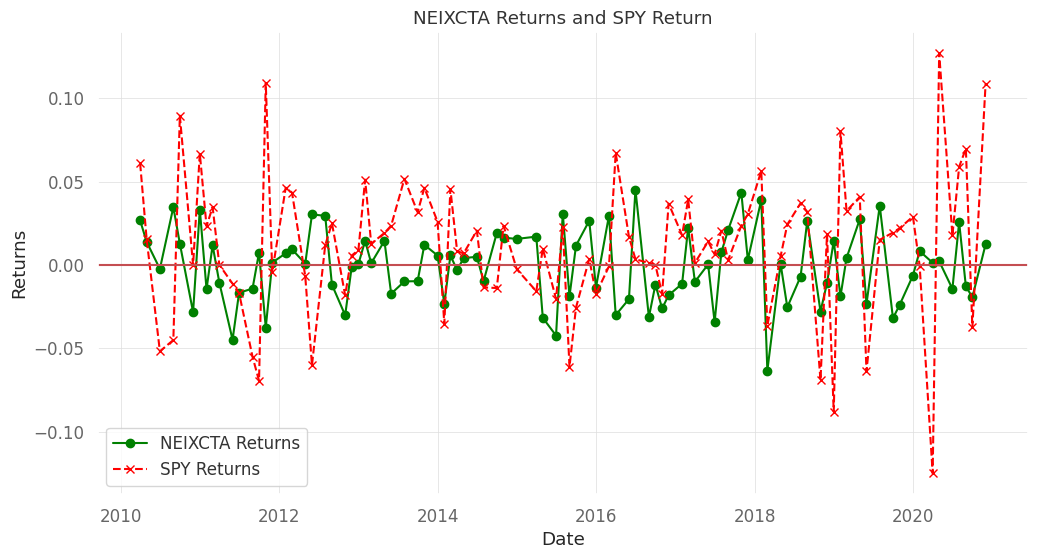

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(combined_data2.index, combined_data2['CTA_pctchange'], label='NEIXCTA Returns', color='green', marker='o')
plt.plot(combined_data2.index, combined_data2['SPY_Monthly_Returns'], label='SPY Returns', color='red', linestyle='--', marker='x')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('NEIXCTA Returns and SPY Return')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


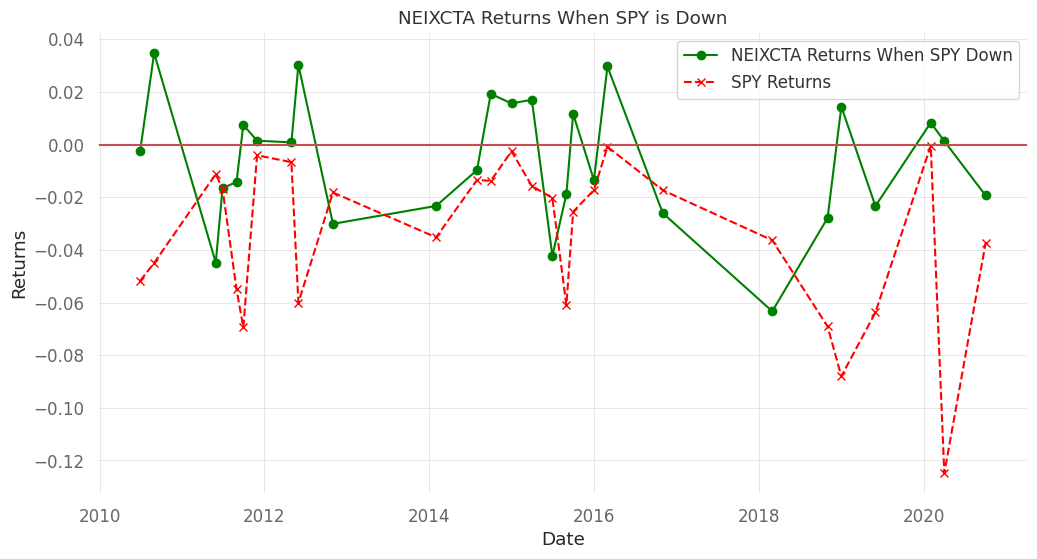

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(down_periods2.index, down_periods2['CTA_pctchange'], label='NEIXCTA Returns When SPY Down', color='green', marker='o')
plt.plot(down_periods2.index, down_periods2['SPY_Monthly_Returns'], label='SPY Returns', color='red', linestyle='--', marker='x')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('NEIXCTA Returns When SPY is Down')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()
